## Train over 25 epochs

In [9]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time

# load data
df = pd.read_csv("preprocessed_reviews.csv")

# tokenize
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# replace out-of-vocab with 0
sequences = [[token if token < 3000 else 0 for token in seq] for seq in sequences]
X = pad_sequences(sequences, maxlen=300)
y = df['sentiment_binary'].values

extra_features = df[['review_length', 'exclamation_count']].values
scaler = StandardScaler()
extra_features_scaled = scaler.fit_transform(extra_features)

# train/test split
X_train_text, X_test_text, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    X, extra_features_scaled, y, test_size=0.2, random_state=42
)

# chosen hyperparameters
lr = 0.01
momentum = 0.9
lstm_units = 128
lstm_layers = 1
embedding_dim = 128
vocab_size = 10000

epochs = 25

print(f"\nTraining with lr={lr}, momentum={momentum}, lstm_units={lstm_units}, lstm_layers={lstm_layers}")
start_time = time.time()

# build model
text_input = Input(shape=(300,), name='text_input')
embedding = Embedding(vocab_size, embedding_dim)(text_input)
lstm = LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)(embedding)

extra_input = Input(shape=(2,), name='extra_input')

combined = Concatenate()([lstm, extra_input])
dense = Dense(64, activation='relu')(combined)
dropout = Dropout(0.3)(dense)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[text_input, extra_input], outputs=output)
optimizer = SGD(learning_rate=lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

history = model.fit(
    {'text_input': X_train_text, 'extra_input': X_train_extra},
    y_train,
    epochs=epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
)

# calculate time took to train model
elapsed = time.time() - start_time


Training with lr=0.01, momentum=0.9, lstm_units=128, lstm_layers=1


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 300, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 128)       │    131,584 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 130)       │          0 │ lstm_5[0][0],     │
│ (Concatenate)       │                   │            │ extra_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,384 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,420,033 (5.42 MB)

 Trainable params: 1,420,033 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5724 - loss: 0.6807 - val_accuracy: 0.5572 - val_loss: 0.6772
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.5881 - loss: 0.6723 - val_accuracy: 0.5800 - val_loss: 0.6730
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5901 - loss: 0.6717 - val_accuracy: 0.5800 - val_loss: 0.6723
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6150 - loss: 0.6562 - val_accuracy: 0.5897 - val_loss: 0.6691
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6130 - loss: 0.6578 - val_accuracy: 0.6041 - val_loss: 0.6657
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6090 - loss: 0.6560 - val_accuracy: 0.6089 - val_loss: 0.6617
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6133 - loss: 0.6544 - val_accuracy: 0.6077 - val_loss: 0.6574
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6160 - loss: 0.6520 - val_accu

## Plot loss and accuracy

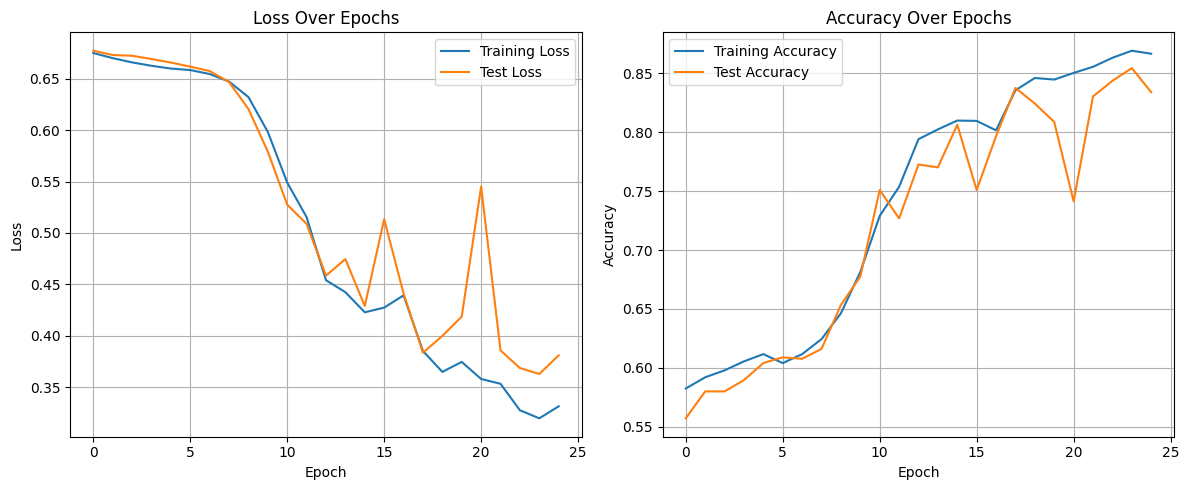

In [10]:
import matplotlib.pyplot as plt

# Plot val_loss and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot val_accuracy and accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Save metrics and model

In [11]:
import os
import json
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# get predictions
y_pred = model.predict({
    'text_input': X_test_text,
    'extra_input': X_test_extra
})
binary_predictions = (y_pred > 0.5).astype(int)
y_test_array = np.array(y_test)

# compute metrics
acc  = accuracy_score(y_test_array, binary_predictions)
prec = precision_score(y_test_array, binary_predictions)
rec  = recall_score(y_test_array, binary_predictions)
f1   = f1_score(y_test_array, binary_predictions)

clf_rep = classification_report(
    y_test_array, binary_predictions,
    target_names=["Negative", "Positive"],
    digits=4
)

# create evaluation directory if doesn't exist
os.makedirs("../evaluation", exist_ok=True)

# save numeric metrics as JSON
metrics = {
    "model": "lstm",
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "time": elapsed
}
with open("../evaluation/lstm_metrics.json", "w") as fp:
    json.dump(metrics, fp, indent=2)

# create confusion matrix plot
cm = confusion_matrix(y_test_array, binary_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Neg","Pos"],
    yticklabels=["Neg","Pos"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.tight_layout()
plt.savefig("../evaluation/lstm_confusion_matrix.png")
plt.close()

print("evaluation metrics & plots saved to /evaluation/")

65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step
evaluation metrics & plots saved to /evaluation/
